In [1]:
import torch

from torchvision.transforms import ToTensor, Compose, Normalize

from data.dataset import get_data

from model.model import YOLONet
from model.train import train
from model.loss import DetectionLoss

from eval.display import plot_losses

DATASET = "../datasets/Human-Fall-Detection"
BATCH_SIZE = 8

SUBSET = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform_data = Compose([ToTensor(), Normalize((0.4379,), (0.3040,))])

data = get_data(DATASET, transform_data, device=device, batch_size=BATCH_SIZE, end=BATCH_SIZE if SUBSET else None)
 
train_loader, val_loader, test_loader = list(data["dataloaders"].values())

  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\yapzh\miniconda3\envs\dlenv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


[1] valid: 3.1995, 51.8870, 2.9590, f1: 0.809 0.033 0.872


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


[2] valid: 3.0332, 51.2392, 2.9004, f1: 0.808 0.033 0.853


100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


Final test loss: tensor([ 2.7816, 74.4051,  2.7705], device='cuda:0'), f1: 0.841 0.000 0.772
Finished Training


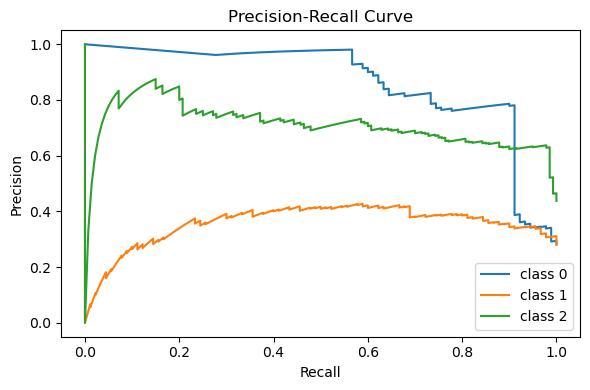

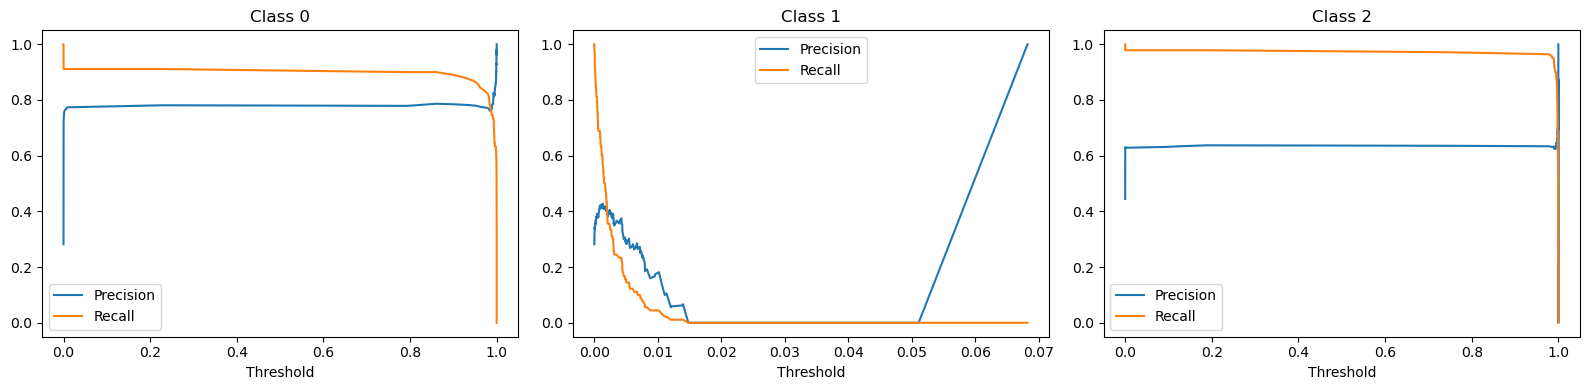

In [3]:
with torch.device(device):
  model = YOLONet(3, ch=(64,32,16))
  model.load_state_dict(torch.load('model_softmax_v3_last.pt'))
  criterion = DetectionLoss(model.head)

res = train(model, train_loader, val_loader, test_loader, 2, criterion)


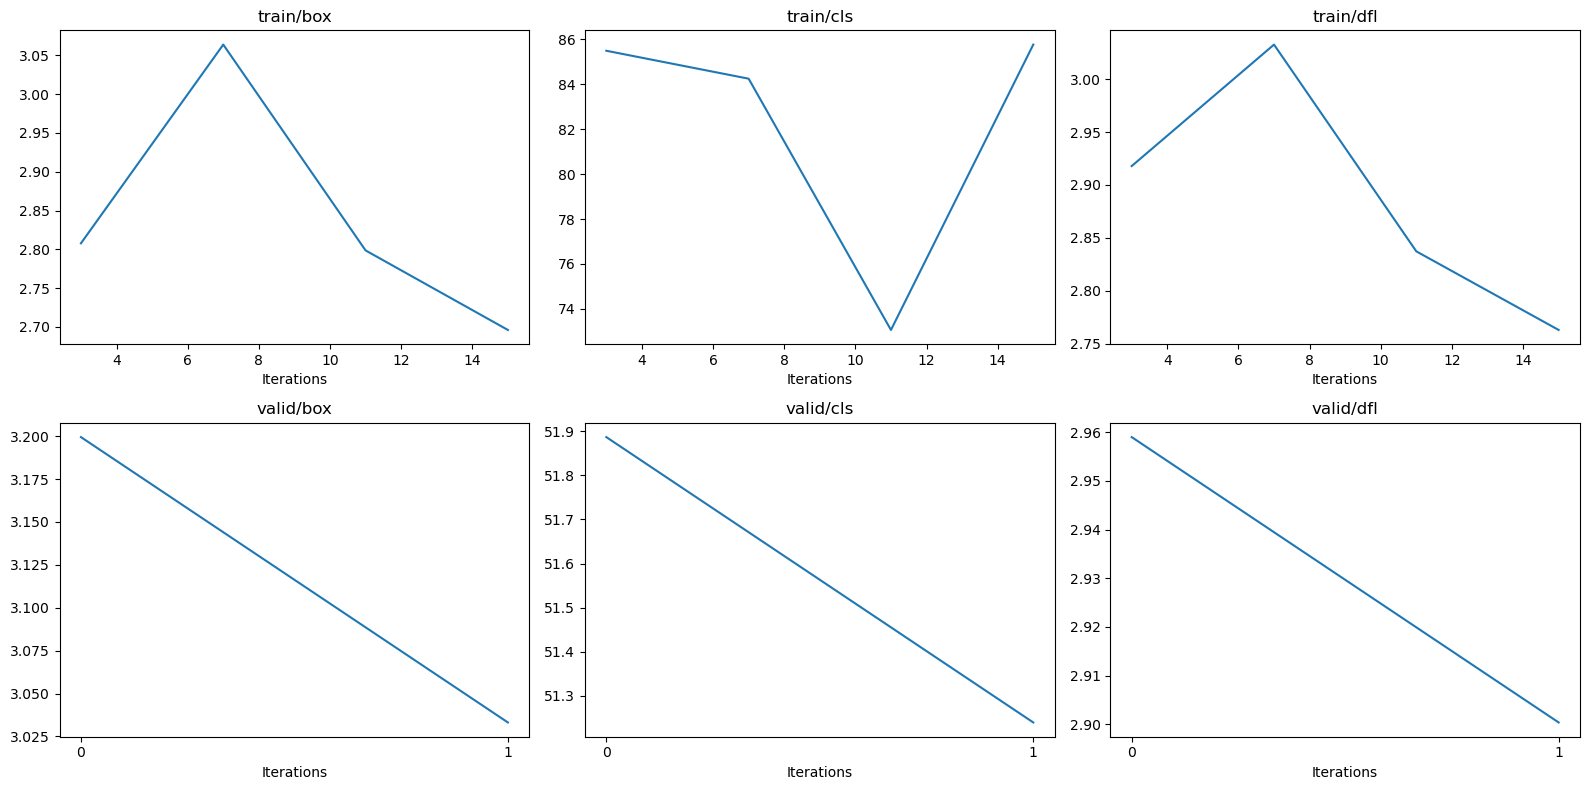

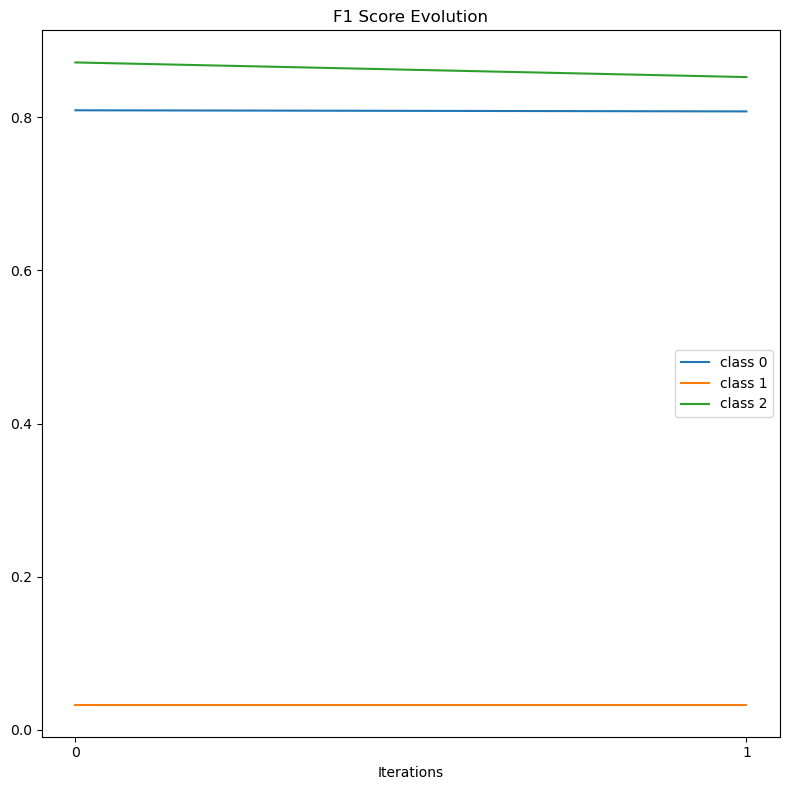

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from eval.display import plot_losses
import numpy as np

# def plot_losses(losses: dict, save_dir: str = "runs"):
#     """
#     Plot loss and f1 score evolution.
#     """

#     fig, axs = plt.subplots(2, 3, figsize=(16, 8))

#     for i, loss in enumerate(['train', 'valid']):
#         for j, ltype in enumerate(['box', 'cls', 'dfl']):
#             ax = axs[i, j]
#             ax.plot(losses[loss]['iter'], losses[loss][ltype])
#             ax.set_title(f"{loss}/{ltype}")
#             ax.set_xlabel("Iterations")
#             ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#     # save fig
#     plt.tight_layout()
#     plt.savefig(f"{save_dir}/losses.png")


#     f1_scores = np.array(losses['valid']['f1']).T
#     fig, ax = plt.subplots(figsize=(8, 8))

#     for i, f1 in enumerate(f1_scores):
#         ax.plot(losses['valid']['iter'], f1, label=f"class {i}")

#     ax.set_title("F1 Score Evolution")
#     ax.set_xlabel("Iterations")
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#     ax.legend()

#     plt.tight_layout()
#     plt.savefig(f"{save_dir}/val_f1.png")

plot_losses(res)

# import numpy as np
# np.array(res['valid']['f1']).T

In [ ]:
# torch.save(model.state_dict(), 'model_sigmoid_e14_last.pt')

In [4]:
model.eval()
image, label = next(iter(test_loader))
print(image.shape)
output = model(image, True)
len(output)

torch.Size([8, 3, 640, 640])


3

In [5]:
_,_, preds, targets = criterion(output, label, True)
preds.shape, targets.shape

c:\Users\yapzh\miniconda3\envs\dlenv\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([320, 3]), torch.Size([320]))

In [16]:
torch.cat([preds, preds], 0).shape

torch.Size([640, 3])

In [15]:
from torcheval.metrics.functional import multiclass_f1_score as f1, multiclass_precision_recall_curve as prc


# res = prc(preds.exp(), targets, num_classes = 3)
# pres, rec, thres = res
# thres
res = f1(preds.exp(), targets, num_classes = 3, average=None)
res

tensor([0.8387, 0.0000, 0.7692], device='cuda:0')

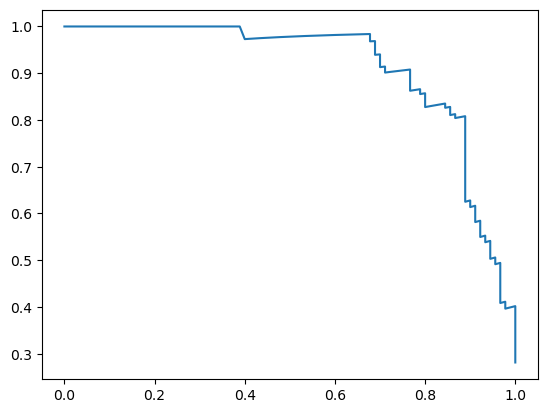

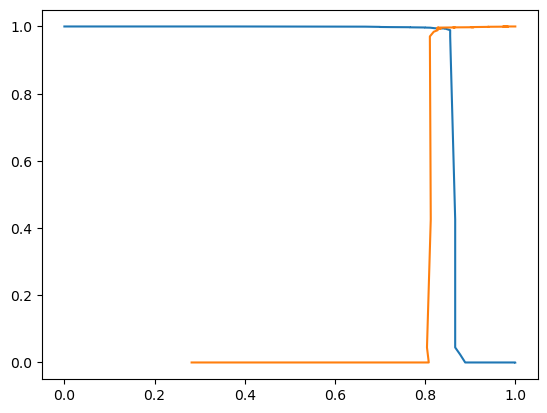

In [10]:
import matplotlib.pyplot as plt

plt.plot(rec[0].cpu().numpy(), pres[0].cpu().numpy(), label='Fall')
plt.show()

plt.plot(rec[0][1:].cpu().numpy(), thres[0].cpu().numpy(), label='Recall')
plt.plot(pres[0][1:].cpu().numpy(), thres[0].cpu().numpy(), label='Precision')
# plt.plot(rec[1].cpu().numpy(), pres[1].cpu().numpy(), label='Sitting')
# plt.plot(rec[2].cpu().numpy(), pres[2].cpu().numpy(), label='Walking')

In [ ]:
target_scores[fg_mask][14]

tensor([0.0000, 0.3270, 0.0000, 0.0000], device='cuda:0')

In [ ]:
output.shape

torch.Size([8, 8, 2100])

In [ ]:
boxes, clses = output.split((4,4), 1)
boxes.shape, clses.shape

(torch.Size([8, 4, 2100]), torch.Size([8, 4, 2100]))

In [ ]:
clses[0, :, 10]

tensor([3.1145e-10, 8.4989e-07, 1.7114e-07, 1.5948e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
conf, cls_ids = torch.max(clses, 1)
conf

tensor([[5.2822e-07, 2.5184e-07, 8.9841e-07,  ..., 4.1890e-07, 3.8147e-07,
         3.9043e-07],
        [2.1585e-05, 2.0487e-06, 1.0129e-06,  ..., 4.0763e-07, 4.8921e-07,
         4.3268e-07],
        [2.9873e-07, 6.2420e-06, 3.4757e-05,  ..., 4.6648e-07, 5.3768e-07,
         4.8996e-07],
        ...,
        [3.3953e-07, 1.5851e-07, 4.0090e-07,  ..., 5.6361e-07, 4.7627e-07,
         3.9615e-07],
        [7.8436e-07, 7.7606e-07, 8.7985e-07,  ..., 6.8960e-07, 5.3947e-07,
         4.6977e-07],
        [2.1245e-07, 1.2516e-07, 2.8890e-07,  ..., 5.0234e-07, 5.7163e-07,
         6.2507e-07]], device='cuda:0', grad_fn=<MaxBackward0>)

In [ ]:
conf

tensor([[5.2822e-07, 2.5184e-07, 8.9841e-07,  ..., 4.1890e-07, 3.8147e-07,
         3.9043e-07],
        [2.1585e-05, 2.0487e-06, 1.0129e-06,  ..., 4.0763e-07, 4.8921e-07,
         4.3268e-07],
        [2.9873e-07, 6.2420e-06, 3.4757e-05,  ..., 4.6648e-07, 5.3768e-07,
         4.8996e-07],
        ...,
        [3.3953e-07, 1.5851e-07, 4.0090e-07,  ..., 5.6361e-07, 4.7627e-07,
         3.9615e-07],
        [7.8436e-07, 7.7606e-07, 8.7985e-07,  ..., 6.8960e-07, 5.3947e-07,
         4.6977e-07],
        [2.1245e-07, 1.2516e-07, 2.8890e-07,  ..., 5.0234e-07, 5.7163e-07,
         6.2507e-07]], device='cuda:0', grad_fn=<MaxBackward0>)

In [ ]:
boxes.shape, conf.shape

(torch.Size([8, 4, 2100]), torch.Size([8, 2100]))

In [ ]:
clses[0].shape

torch.Size([4, 2100])

In [ ]:
from model.model import nms, multibox_detection

In [ ]:
keep = nms(boxes[0], conf[0], 0.5)

In [ ]:
boxes, clses = output.split((4,4), 1)
cls_probs = clses
pred_bboxes = boxes
nms_threshold = 0.5
pos_threshold = 0.01

device, batch_size = cls_probs.device, cls_probs.shape[0]
num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
out = []
# for i in range(batch_size):
i = 0
cls_prob, predicted_bb = cls_probs[i], pred_bboxes[i]
conf, class_id = torch.max(cls_prob, 0)

keep = nms(predicted_bb, conf, nms_threshold)
print(keep)
# Find all non-`keep` indices and set the class to background
all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
combined = torch.cat((keep, all_idx))
uniques, counts = combined.unique(return_counts=True)
non_keep = uniques[counts == 1]
print(non_keep.shape)
all_id_sorted = torch.cat((keep, non_keep))
class_id[non_keep] = 0
class_id = class_id[all_id_sorted]
conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
# Here `pos_threshold` is a threshold for positive (non-background)
# predictions
below_min_idx = (conf < pos_threshold)
below_min_idx.shape
# class_id[below_min_idx] = -1
# conf[below_min_idx] = 1 - conf[below_min_idx]
# pred_info = torch.cat((class_id.unsqueeze(1),
#                         conf.unsqueeze(1),
#                         predicted_bb), dim=1)
# out.append(pred_info)

tensor([2047, 2080, 2011, 2009, 2089, 1827, 1836, 1737, 1684, 1773, 1951, 1690,
        1658, 1884, 1680, 1628, 1935, 1941, 1967, 1602, 1780,  757, 1872, 1614,
         203, 1899, 1997,  874, 1748,  372,  981,  385,   45,  260,  325,  935,
         592,  539,  518, 1036,  176,   66,  354,  739, 1455,  628, 1112, 1222,
         279,  950,   62, 1133,  190,  527,  416,  168,  562,  360,  132, 1541,
         762, 1475,  827, 1401, 1330,   78,  615,  773,  847, 1345, 1042, 1105,
        1445,  704, 1399,  430, 1098,   40,   33,  971, 1470, 1204, 1339, 1276,
        1269, 1159, 1587,  689, 1128, 1598, 1572], device='cuda:0')
torch.Size([2009])


torch.Size([2100])

In [ ]:
class_id.shape

torch.Size([2100])

In [ ]:
class_id[all_id_sorted]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
class_id.shape

torch.Size([2100])

In [ ]:
out = multibox_detection(boxes, clses, 0.5)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
keep.shape

torch.Size([96])

In [ ]:
boxes.shape, conf.shape

(torch.Size([8, 4, 2100]), torch.Size([8, 2100]))

In [ ]:
boxes.transpose(1,2).shape

torch.Size([8, 2100, 4])

In [ ]:
B = torch.argsort(conf[0, :], dim=-1, descending=True)
B.shape

torch.Size([2100])

In [ ]:
B

tensor([1634, 1627, 1633,  ..., 1054,    2,    1], device='cuda:0')

In [ ]:
cls_probs = clses
pred_bboxes = boxes

i=0

cls_prob, predicted_bb = cls_probs[i], pred_bboxes[i].reshape(-1, 4)
conf, class_id = torch.max(cls_prob[1:], 0)

In [ ]:
conf

tensor([0.0010, 0.0007, 0.0007,  ..., 0.0102, 0.0106, 0.0092], device='cuda:0',
       grad_fn=<MaxBackward0>)

In [ ]:
cls_prob[1:, 0]

tensor([0.0010, 0.0007, 0.0004], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
boxes.shape, boxes[0].shape

(torch.Size([8, 4, 2100]), torch.Size([4, 2100]))

In [ ]:
boxes[0].reshape(-1,4).shape

torch.Size([2100, 4])

In [ ]:
pred_boxes = boxes[0, :, :]

In [ ]:
from utils import bbox_iou

In [ ]:
pred_boxes.shape

torch.Size([4, 2100])

In [ ]:
B

tensor([1634, 1627, 1633,  ..., 1054,    2,    1], device='cuda:0')

In [ ]:
pred_boxes[:, B[1:]].shape

torch.Size([4, 2099])

In [ ]:
conf[fg_mask]

tensor([0.0007, 0.0008, 0.0010,  ..., 0.0090, 0.0104, 0.0100], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [ ]:
cls_ids[cls_ids != 0].shape

torch.Size([12724])

In [ ]:
clses[0, :, 0].exp()

tensor([3.9222e-05, 5.5511e-04, 9.9941e-01], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [ ]:
image, label = next(iter(test_loader))

In [ ]:
from tqdm import tqdm

pbar = tqdm(test_loader)
for i, (image, label) in enumerate(pbar):
  # print(image.shape, label.shape)
  pbar.set_description_str(f"{image.shape} {label.shape}")
  continue
  output = model(image)
  pbar.set_description_str(f"{output.shape}")
  # boxes, clses = output.split((4,3), 1)
  # conf, cls_ids = clses.max(1)
  # print(cls_ids)
  # break

torch.Size([7, 3, 640, 640]) torch.Size([10, 6]): 100%|██████████| 113/113 [00:07<00:00, 14.80it/s]
